In [44]:
import pandas as pd
import numpy as np
import requests
import re
from Bio import SeqIO
import subprocess
from random import sample
from scipy.stats import entropy
import json
import seaborn as sns


def ko2genes(ko):
    url = 'http://rest.kegg.jp/link/genes/' + ko
    r = requests.get(url)
    geneKO = pd.DataFrame([x.split('\t') for x in r.text.split('\n')],columns=['ko','gene'])
    geneKO = geneKO.iloc[0:-1]
    return geneKO

def download_seqs(geneList,fileName,batchSize):    
    geneList_chunks = [geneList[i * batchSize:(i + 1) * batchSize] for i in range((len(geneList) + batchSize - 1) // batchSize )]
    with open(fileName,'w') as fastafile:
        for sglist in geneList_chunks:
            url =  'http://rest.kegg.jp/get/' + "+".join(sglist) + '/aaseq'
            fseqs = requests.get(url).text
            fastafile.write(fseqs)

            
def msaSeq2df(seq,indexStart):
    idx = []
    resid = []
    j = indexStart;
    for i in seq:
        resid.append(i)
        if i == '-':
            idx.append(np.nan)
        else:
            idx.append(j)
            j = j+1
    
    return pd.DataFrame({'residue': resid, 'index': idx})

def ecogenes():
    url = 'http://rest.kegg.jp/link/ko/eco'
    r = requests.get(url)
    geneKO = pd.DataFrame([x.split('\t') for x in r.text.split('\n')],columns=['gene','ko'])
    geneKO = geneKO.iloc[0:-1]
    return geneKO

get_resid = lambda x: [x for x in re.findall(r'\D',x) if len(x)>0][0]
get_resid_idx = lambda x: [int(x) for x in re.findall(r'\d*',x) if len(x)>0][0]


# load all structural annotations
structure = pd.read_csv('../../assets/structure/residueTable.66genes.csv',index_col=0)

structure['gene name (KO)'] = structure['gene name'] + ' (' + structure['KO'] + ')'

In [239]:
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 10
import seaborn as sns

In [3]:
with open("../assets/catalytic_residues_homologues.json", "r") as read_file:
    mcsa = json.load(read_file)

In [8]:
#list(mcsa)[0]

In [178]:
residues = []
for m in mcsa:
    m2 = pd.DataFrame(m['residue_sequences'])
    m2['msa_id'] = m['mcsa_id']
    residues.append(m2)
residues = pd.concat(residues,axis=0)

In [47]:
#structure = pd.read_csv('../../assets/structure/residueTable.66genes.csv',index_col=0)

In [179]:
active_site_residues = residues[residues.uniprot_id.isin(structure['Homolog-Uniprot'].tolist())]

In [180]:
active_site_residues

,code,resid,uniprot_id,is_reference,msa_id
30,Cys,49.0,P09063,False,6
64,Cys,47.0,P06715,False,6
41,Tyr,182.0,P09063,False,6
60,Tyr,177.0,P06715,False,6
61,Cys,42.0,P06715,False,6
...,...,...,...,...,...
214,Arg,240.0,P0A9T0,False,902
205,Glu,269.0,P0A9T0,False,902
152,His,292.0,P0A9T0,False,902
267,Cys,150.0,P0A9B2,False,911


In [181]:
z = structure[structure['Homolog-Uniprot'].isin(active_site_residues.uniprot_id.tolist())]

In [206]:
residues = np.array(['-', 'A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'N', 'Q', 'R', 'S', 'T', 'V', 'M', 'Y', 'P', 'W'])
# all active sites
dfs = []
for gene,row in z.iterrows():
    ko = row.KO
    seq_id = row['Homolog-KEGG']
    msa_file = '../../assets/kegg_seqs_1k_allGenes/msa/' + ko + '.MSA.fasta'
    seq_dict = SeqIO.to_dict(SeqIO.parse(msa_file,'fasta'))
    if seq_id in seq_dict:
        seq = str(seq_dict[seq_id].seq)

        seqdf = msaSeq2df(seq,1)
        uniprot = row['Homolog-Uniprot']
        r_resids = active_site_residues[active_site_residues.uniprot_id == uniprot][['code','resid','uniprot_id']].drop_duplicates().dropna()
        
        #r_resids = active_site_residues[active_site_residues.uniprot_id.isin([uniprot])]
        r_resids = seqdf[seqdf['index'].isin(r_resids.resid)]
        entropies = []
        for idx2,row2 in r_resids.iterrows():
            chars = [y.seq[idx2] for y in list(seq_dict.values())]
            c= [chars.count(x) for x in residues]
            c = [x + 0.5 for x in c]
            pk = np.array(c)/sum(c)
            site_entropy = entropy(pk)
            entropies.append(site_entropy)

        r_resids['uniprot'] = uniprot
        r_resids['ko'] = ko
        r_resids['kegg'] = seq_id
        r_resids['entropy'] = entropies
        r_resids['Coenzyme'] = row['Coenzyme']
        dfs.append(r_resids)

dfs_active_site_residues = pd.concat(dfs,axis=0)

<ipython-input-206-4ada16cb2079>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  r_resids['uniprot'] = uniprot
<ipython-input-206-4ada16cb2079>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  r_resids['ko'] = ko
<ipython-input-206-4ada16cb2079>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#re

In [210]:
dfs_active_site_residues

,residue,index,uniprot,ko,kegg,entropy,Coenzyme
529,H,159.0,P04036,K00215,eco:b0031,0.188548,NAD
533,K,163.0,P04036,K00215,eco:b0031,0.154668,NAD
599,P,16.0,P09063,K00382,ppu:PP_4404,0.854968,NAD
645,L,40.0,P09063,K00382,ppu:PP_4404,1.455894,NAD
649,C,44.0,P09063,K00382,ppu:PP_4404,0.130052,NAD
...,...,...,...,...,...,...,...
1096,F,223.0,P0AEZ1,K00297,eco:b3941,1.860942,NADH
1468,H,273.0,P0AEZ1,K00297,eco:b3941,0.349232,NADH
1010,R,166.0,Q9HZM7,K00075,pae:PA2977,0.197603,NADP
1291,S,239.0,Q9HZM7,K00075,pae:PA2977,0.285647,NADP


In [211]:

ko_list =  [];
residue_list = []
residue_ref_idx = []
residue_msa_idx = []
count_occured = []
count_not_occured = []
frac_occured = []

dfs = []
residues = np.array(['-', 'A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'N', 'Q', 'R', 'S', 'T', 'V', 'M', 'Y', 'P', 'W'])
for idx,row in structure.iterrows():
    ko = row.KO
    msa_file = '../../assets/kegg_seqs_1k_allGenes/msa/' + ko + '.MSA.fasta'
    seq_dict = SeqIO.to_dict(SeqIO.parse(msa_file,'fasta'))
    if structure[structure.KO == ko]['Homolog-KEGG'].tolist()[0] in list(seq_dict):
        seq_id = structure[structure.KO == ko]['Homolog-KEGG'].tolist()[0]
        r = structure[structure.KO == ko].Residues[0].split(';')
        r  = [x for x in r if x not in ['Unclear',None]]
        if len(r) > 0:
            r = pd.DataFrame({'residue': [get_resid(y) for y in r],'index':[get_resid_idx(y) for y in r]})
            seq = str(seq_dict[seq_id].seq)
            seqdf = msaSeq2df(seq,1)
            sdf = seqdf[seqdf['index'].isin(r['index'].tolist())]
            for midx,row2 in sdf.iterrows():
                chars = [y.seq[midx] for y in list(seq_dict.values())]
                
                #c = [chars.count(x) for x in list(set(chars))]
                c= [chars.count(x) for x in residues]
                c = [x + 0.5 for x in c]
                pk = np.array(c)/sum(c)
                site_entropy = entropy(pk)
                
                z = pd.DataFrame({'idx':chars}).reset_index().groupby('idx').count()
                z2 = z.reset_index()
                z2.columns = ['residue','numSeqs']
                z2['ref_residue'] = row2.residue
                z2['ref_residue_idx'] = row2['index']
                z2['entropy'] = site_entropy
                z2['KO'] = ko
                z2['Coenzyme'] = row.Coenzyme
                dfs.append(z2)
                #frac = z.loc[row2.residue]['index'] / z['index'].sum()
                ##ko_list.append(ko)
                #residue_list.append(row2.residue)
                #residue_ref_idx.append(row2['index'])
                #residue_msa_idx.append(midx)
                #count_occured.append(z.loc[row2.residue]['index'])
                #count_not_occured.append(z['index'].sum() - z.loc[row2.residue]['index'])
                #frac_occured.append(frac)

dfs_coenzyme = pd.concat(dfs,axis=0)                

#r = r[r['wt_residue'].apply(lambda x: x[0] in ['D','E'])]
#results = pd.DataFrame({'ko':ko_list,'residue':residue_list,'idx': residue_ref_idx, 'midx': residue_msa_idx, 'count': count_occured, 'ncount': count_not_occured, 'frac': frac_occured})    

In [212]:
dfs_coenzyme

,residue,numSeqs,ref_residue,ref_residue_idx,entropy,KO,Coenzyme
0,-,258,E,38.0,1.888932,K00215,NAD
1,A,27,E,38.0,1.888932,K00215,NAD
2,C,10,E,38.0,1.888932,K00215,NAD
3,D,280,E,38.0,1.888932,K00215,NAD
4,E,239,E,38.0,1.888932,K00215,NAD
...,...,...,...,...,...,...,...
11,R,5,N,58.0,1.692463,K00040,NADH
12,S,300,N,58.0,1.692463,K00040,NADH
13,T,83,N,58.0,1.692463,K00040,NADH
14,V,24,N,58.0,1.692463,K00040,NADH


In [213]:
e = dfs_coenzyme[['KO','entropy','ref_residue_idx','Coenzyme']].drop_duplicates()

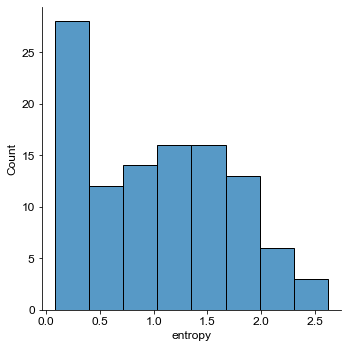

In [214]:
sns.displot(x='entropy',data=e)

In [215]:

ko_list =  [];
residue_list = []
residue_ref_idx = []
residue_msa_idx = []
count_occured = []
count_not_occured = []
frac_occured = []

dfs = []
residues = np.array(['-', 'A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'N', 'Q', 'R', 'S', 'T', 'V', 'M', 'Y', 'P', 'W'])
for idx,row in structure.iterrows():
    ko = row.KO
    msa_file = '../../assets/kegg_seqs_1k_allGenes/msa/' + ko + '.MSA.fasta'
    seq_dict = SeqIO.to_dict(SeqIO.parse(msa_file,'fasta'))
    if structure[structure.KO == ko]['Homolog-KEGG'].tolist()[0] in list(seq_dict):
        seq_id = structure[structure.KO == ko]['Homolog-KEGG'].tolist()[0]
        r = structure[structure.KO == ko].Residues[0].split(';')
        r  = [x for x in r if x not in ['Unclear',None]]
        if len(r) > 0:
            r = pd.DataFrame({'residue': [get_resid(y) for y in r],'index':[get_resid_idx(y) for y in r]})
            seq = str(seq_dict[seq_id].seq)
            seqdf = msaSeq2df(seq,1)
            sdf = seqdf
            for midx,row2 in sdf.iterrows():
                chars = [y.seq[midx] for y in list(seq_dict.values())]
                
                #c = [chars.count(x) for x in list(set(chars))]
                c= [chars.count(x) for x in residues]
                c = [x + 0.5 for x in c]
                pk = np.array(c)/sum(c)
                site_entropy = entropy(pk)
                
                z = pd.DataFrame({'idx':chars}).reset_index().groupby('idx').count()
                z2 = z.reset_index()
                z2.columns = ['residue','numSeqs']
                z2['ref_residue'] = row2.residue
                z2['ref_residue_idx'] = row2['index']
                z2['entropy'] = site_entropy
                z2['KO'] = ko
                z2['Coenzyme'] = row.Coenzyme
                dfs.append(z2)
                #frac = z.loc[row2.residue]['index'] / z['index'].sum()
                ##ko_list.append(ko)
                #residue_list.append(row2.residue)
                #residue_ref_idx.append(row2['index'])
                #residue_msa_idx.append(midx)
                #count_occured.append(z.loc[row2.residue]['index'])
                #count_not_occured.append(z['index'].sum() - z.loc[row2.residue]['index'])
                #frac_occured.append(frac)

dfs_all_resids = pd.concat(dfs,axis=0)                

#r = r[r['wt_residue'].apply(lambda x: x[0] in ['D','E'])]
#results = pd.DataFrame({'ko':ko_list,'residue':residue_list,'idx': residue_ref_idx, 'midx': residue_msa_idx, 'count': count_occured, 'ncount': count_not_occured, 'frac': frac_occured})    

In [216]:
e_all_resids = dfs_all_resids.dropna()[['KO','entropy','ref_residue_idx','Coenzyme']].drop_duplicates()

In [217]:
e_all_resids

,KO,entropy,ref_residue_idx,Coenzyme
0,K00215,1.058286,1.0,NAD
0,K00215,1.388960,2.0,NAD
0,K00215,1.664972,3.0,NAD
0,K00215,1.952988,4.0,NAD
0,K00215,2.287368,5.0,NAD
...,...,...,...,...
0,K00040,2.241994,482.0,NADH
0,K00040,2.016212,483.0,NADH
0,K00040,2.129576,484.0,NADH
0,K00040,2.483342,485.0,NADH


In [218]:
df_asr = pd.DataFrame({'resid': 'active site', 'entropy': dfs_active_site_residues['entropy'].tolist(),'coenzyme':dfs_active_site_residues['Coenzyme'].tolist()})
df_c = pd.DataFrame({'resid': 'coenzyme', 'entropy': e['entropy'].tolist(), 'coenzyme': e['Coenzyme'].tolist()})
df_ar = pd.DataFrame({'resid': 'all residues', 'entropy': e_all_resids['entropy'].tolist(), 'coenzyme': e_all_resids['Coenzyme'].tolist()})

In [219]:
df_r = pd.concat([df_asr,df_c,df_ar],axis=0)

In [220]:
df_r


,resid,entropy,coenzyme
0,active site,0.188548,NAD
1,active site,0.154668,NAD
2,active site,0.854968,NAD
3,active site,1.455894,NAD
4,active site,0.130052,NAD
...,...,...,...
23414,all residues,2.241994,NADH
23415,all residues,2.016212,NADH
23416,all residues,2.129576,NADH
23417,all residues,2.483342,NADH


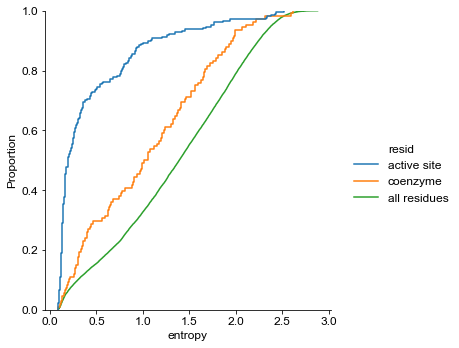

In [221]:
sns.displot(x='entropy',data=df_r,kind='ecdf',hue='resid')

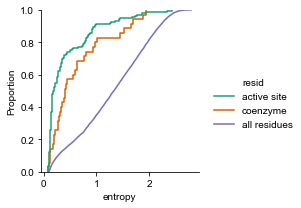

In [240]:
df_r_ss = df_r[df_r.coenzyme.isin(['NAD','NADH'])]
sns.displot(x='entropy',data=df_r_ss,kind='ecdf',hue='resid',palette='Dark2',height=3)
plt.savefig('nadh.residueConservation.svg')

In [232]:
df_r_ss.groupby('resid').count()

,entropy,coenzyme
resid,,
active site,136,136
all residues,13548,13548
coenzyme,35,35


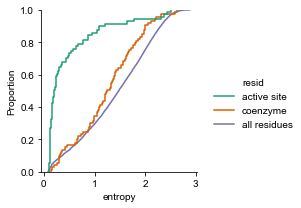

In [241]:
df_r_ss = df_r[df_r.coenzyme.isin(['NADP','NADPH'])]
sns.displot(x='entropy',data=df_r_ss,kind='ecdf',hue='resid',palette='Dark2',height=3)
plt.savefig('nadph.residueConservation.svg')

In [234]:
df_r_ss.groupby('resid').count()

,entropy,coenzyme
resid,,
active site,71,71
all residues,9871,9871
coenzyme,73,73


In [198]:
len(df_c)

108

In [199]:
len(df_ar)

23419